<h1> How I learned to stop worrying and love uncertainty </h1>

An introductory workshop on quantifying uncertainty in building simulation.

<b>author</b>: Parag Rastogi; <b>venue</b>: TU Delft, Delft, The Netherlands; <b>date</b>: 04 June, 2018.

Run each module one-by-one by either using the <kbd>run cell</kbd> button above or pressing <kbd>Ctrl + Enter</kbd> when a cell is selected. Modules like this one are `Markdown` modules, which is a kind of text-encoding language. These will not produce an output - instead you will see formatted text in the cell when you run one.


<h2>Initialisation</h2>

<ol>
<li>If you haven't read the wiki, I suggest starting there: https://github.com/paragrastogi/SimAud_2018_Uncertainty/wiki . 

<li> Download the weather data given here: https://drive.google.com/drive/folders/15hyS_Rg-DMxu05FkoS_K-NfFdAozvgJK?usp=sharing . You will see two folders in there: `ddn` and `gen`. Place them in the top-level directory, i.e., at the same level as `lib`.

</ol>

Everything should work ok on a Mac, though I have only tested the exercises on Windows and Ubuntu. 

In [ ]:
# Python contains a lot of in-built commands but its functionality can be super-charged
# with external libraries or modules.

# Import a module that lets us use operating-system type commands
# to create file paths, check if files exist, and so on.
import os

# Import a couple of packages to display images in the notebook.
from IPython.display import Image, display
from IPython.core.display import HTML 

<h2>Uncertainty and Building Simulation</h2>

Uncertainty in engineering calculations arises from a lack of knowledge about the inputs and parameters of these calculations. In other words, not knowing the inputs to a calculation accurately and precisely affects our ability to know the accuracy of outputs.

Building Performance Simulation (BPS) is an estimate of the (thermal and electrical) energy performance of a building. The usual goal of the design process is to obtain a high-performance design, based on some criteria determined by the designer. However, performance depends on several factors outside of the building design, e.g., weather and usage. In common practice, accurate values of these inputs are either difficult or impossible to obtain. That is, we may have some estimates but we cannot access the true value of some input to our calculation, such as future weather conditions.

Thus, a common way to quantify this uncertainty is to sample ranges of plausible values of uncertain inputs. Simulating with different combinations of plausible input values gives a range of outputs, which is representative of the possible outputs to be expected. Using BPS, for example, "... designers can obtain reliable performance estimates by testing their designs under many plausible operating conditions, e.g., the weather and usage the building might experience in the future. These estimates can then be used to choose a design that could deliver high performance for the rest of its life..." (Rastogi, Khan, and Andersen 2018, <i>in review</i>). This is called robust or resilient design. In this workshop, we will work towards the goal of high-performance, robust design with uncertain inputs.

"Unfortunately, multiple simulations are time-consuming... Standard averaging methods, such as the Monte Carlo method, typically require a large number of simulations to ensure the quality of the estimate (MacDonald  2002; Iaccarino 2008}. In a typical building-design problem where a designer might test hundreds of designs, such methods might require hundreds of hours to run and quickly become infeasible. A preferred practice is to simply use a single 'average' or 'typical' estimate of future conditions, which is much faster. The danger of such a procedure is that it might miss a harmful operating condition where the building performs poorly or even breaks down. To ensure the robustness of designs it is, therefore, better to test them under a wide variety of plausible operating conditions." (Rastogi, Khan, and Andersen 2018, <i>in review</i>)

So is it possible to reduce the computation time of BPS such that multiple simulations during the design process are feasible?

Yes it is! With a rapid-response regression model, which we call an 'emulator' (because it emulates the original, physics-based building performance simulation model). A regression model can be used to answer questions about a building's response to changing inputs rapidly, such as may be required by robust design.


In [ ]:
print("Figure 1")
display(Image(filename=os.path.join("..", "img", "MonteCarloSimulation-01.png"), width=1000))
print('===========')

*Figure 1*: A schematic of a decision-making process based on multiple simulations. If multiple designs (B_i) are to be evaluated, then it is better to make decisions knowing the full range of possible performance outcomes based on uncertain inputs.

In [ ]:
print("Figure 2")
display(Image(filename=os.path.join("..", "img", "y_all_years.png"), width=1000))

*Figure 2*: Energy used for space conditioning for an apartment building in Geneva, Switzerland, over one year. Positive energy use means heating is required while negative means cooling is required. Each time series was smoothed with a moving average filter (window=720). The grey lines are for simulations with measured data from 1981 to 2016. Typical 1 and 2 refer to simulation with 'typical' weather data. The distribution is obtained by simulating using
synthetic time series of weather generated by the procedure described in Rastogi and Andersen [2015, 2016], Rastogi [2016]. One can clearly see that simulating with just the typical weather data would not have given any indication of the range of possible heating and cooling energy use values.

<h2>Types of uncertainty and exercises</h2>

The uncertainty in inputs can be separated into two types:

<ol>
    <li> Epistemic - lack of knowledge
    <li> Aleatory - inherent randomness
</ol>

In general, epistemic uncertainty can be reduced with better knowledge but aleatory cannot. Sometimes natural phenomena that appear aleatory, as in inherently random, may not be so; it could just be that our lack of knowledge about these phenomena makes them seem random. The climate is a good example of this.

<strong>Write down two examples of epistemic and aleatory uncertainty related to building simulation, performance, or design.</strong>

In this exercise we will use a regression model (black-box model) to estimate the response of a building. We will do an exercise related to epistemic uncertainty and one related to aleatory. The rest of the workshop is structured as follows:

<ol>
    <li> Loading python modules and weather files.
    <li> Black-box models.
    <li> Epistemic uncertainty with black-box models.
    <li> Aleatory uncertainty with black-box models.
</ol>


In [ ]:
# Import various standard modules.
import glob
import os
import pickle
import copy
import datetime
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Plotting modules.
import matplotlib.pyplot as plt
# import seaborn as sns

# Get inline graphs .
%matplotlib inline

# Only useful for debugging, when you 
# need to reload external modules.
from importlib import reload

# Enable xkcd mode - if you're a nerd.
# plt.xkcd()

# Import a custom read-write function for weather files.
import wfileio as wf

# import small helpers I've written.
import petites as petite

# Import an awesome colour palette. Call it colours.
import default_colours as colours

# Set the random seed to a specific value so
# the experiment is repeatable.
# See https://en.wikipedia.org/wiki/Random_seed
# for more information on what this means.
np.random.seed(42)

In [ ]:
# Declare a function for smoothing data, to be used later.

def smoother(xin, lags):
    
    xout = np.zeros_like(xin)
    
    # Convert even numbers to odd.
    if np.mod(lags, 2) == 0:
        lags = lags + 1
        
    halfspan = int(np.floor(lags/2))
        
    for n, x in enumerate(xin):
        
        if (n < halfspan):
            xout[n] = np.nanmean(xin[0:halfspan])
        
        elif (n > (xin.shape[0] - halfspan)):
            xout[n] = np.nanmean(xin[-halfspan:-1])
        
        else:
            lb = int(n - halfspan)
            ub = int(n + halfspan)
            xout[n] = np.nanmean(xin[lb:ub])
        
        # End IF statement.
        
    # End FOR loop.
    
    return xout

# Define a function that calculates a "circular" rolling mean. That is, it pads 
# the first day of the year with the last day to ensure that the beginning is smooth.

def circ_rolling_mean(df, window=730):
    ''' Circular moving average filter window.'''

    window_copy = copy.deepcopy(df.iloc[-window:])
    
    if isinstance(window_copy.index, pd.core.index.MultiIndex): 
    
        first_index = set(window_copy.index.get_level_values(0))
        
        w_index = window_copy.index.get_level_values(1) - pd.DateOffset(hours=8760)
        
    else:
        w_index = window_copy.index - pd.DateOffset(hours=8760)
    
    window_copy.index = w_index
        
    df_copy = (pd.concat([window_copy, df])).rolling(window=window).mean()
    
    return df_copy[window:]

In [ ]:
# Read Dehradun and Geneva location data.

# We will store some metadata about the stations as well.
metadata = dict(locdata=list(), header=list())

# We will only use the EPW file format for this exercise.
file_type = 'epw'

# I use os.path.join so the paths are automatically constructed based on the OS.
path_epw_ddn = os.path.join('..', 'ddn', 'IND_UT_Dehradun.421110_ISHRAE2014.epw')

# The small program get_weather stores data from the incoming weather
# file as a dataframe.
ddn, locdata, header = wf.get_weather('ddn', path_epw_ddn, file_type=file_type)

# Save some metadata about the location.
metadata['locdata'].append(locdata)
metadata['header'].append(header)

# Do the same with Geneva data. Except Geneva has multiple weather files, so use a loop.
path_gen_folder = os.path.join('..', 'gen', 'historical')
list_genfiles = glob.glob(os.path.join(path_gen_folder, '*.{:s}'.format(file_type)))

# Declare a list.
gen_list = list()

for file in list_genfiles:
    
    gen_temp, locdata, header = wf.get_weather('gen', file, file_type=file_type)
    gen_list.append(gen_temp)
    
# Keep the list - useful for plotting and stuff later.
gen = pd.concat(gen_list)

metadata['locdata'].append(locdata)
metadata['header'].append(header)


In [ ]:
print('DEHRADUN')

print(ddn.describe())

print('======\r\n')

print('GENEVA')

print(gen.describe())

print('======')

In [ ]:
# Calculate the monthly mean values of weather parameters for Dehradun.

relevant_keys = ['tdb', 'dni', 'ghi', 'wspd']
span = 730

# Each weather parameter is grouped by month, and the monthly mean calculated.
# We only keep the relevant keys (relevant for the energy calculation below, that is.)
ddn_summary = ddn.groupby(by=['month']).mean()[relevant_keys]
# Assign an index to the dataframe - useful for plotting.    
ddn_summary.index = pd.unique(ddn['month'])

# Calculate a smoothed version of the original hourly signal using a rolling mean.
ddn_smooth = circ_rolling_mean(ddn[relevant_keys])

# Do the same for Geneva.
gen_summary = list()
gen_smooth = list()
for yearlong in gen_list:
    
    temp_summary = yearlong.groupby(by=['month']).mean()[relevant_keys]
    # Assign an index to the dataframe - useful for plotting.    
    temp_summary.index = pd.unique(yearlong['month'])
    gen_summary.append(temp_summary)

    # Calculate a smoothed version of the original hourly signal using a rolling mean.
    gen_smooth.append(circ_rolling_mean(yearlong[relevant_keys]))

# # Set the variable 'tmy' to the incoming data from Dehradun - so changing 
# # this statement will allow you to run the worksheet with any location.
# tmy = ddn

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 12)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

# Find the index and value of the max and min temperatures.
ymax = list()
ymin = list()
xmax = list()
xmin = list()

ddn_temp_vals = ddn['tdb'].values
ymax.append(np.max(ddn_temp_vals))
xmax.append(np.argmax(ddn_temp_vals))
ymin.append(np.min(ddn_temp_vals))
xmin.append(np.argmin(ddn_temp_vals))

gen_temp_vals = gen['tdb'].values
ymax.append(np.max(gen_temp_vals))
ymin.append(np.min(gen_temp_vals))

plot_x = np.arange(0, ddn.shape[0])
ax[0].plot(plot_x, ddn_smooth['tdb'].values, zorder=10, color=colours.blue)
ax[0].plot(plot_x, ddn['tdb'].values, zorder = 1, color=colours.orange, alpha=0.5)
ax[0].plot(plot_x, np.repeat(ddn_summary['tdb'], 8760/12), color=colours.blackest, zorder=11)


for raw, smooth, summary in zip(gen_list, gen_smooth, gen_summary):
    
    ax[1].plot(plot_x, smooth['tdb'], zorder=10, color=colours.blue, alpha=0.75)
    
    raw_temp_vals = raw['tdb'].values
    
    if np.unique(raw.index.year)==2223:
        ax[1].plot(plot_x, raw_temp_vals, zorder = 12, color=colours.grey)
    else:
        ax[1].plot(plot_x, raw_temp_vals, zorder = 1, color=colours.orange, alpha=0.25)
    
    if ymin[1] in raw_temp_vals:
        xmin.append(np.argmin(raw_temp_vals))
    
    if ymax[1] in raw_temp_vals:
        xmax.append(np.argmax(raw_temp_vals))

#     ax[1].plot(plot_x, np.repeat(summary['tdb'], 8760/12), color=colours.blackest, zorder=11)

for ax_temp in ax:
    ax_temp.set_ylabel('Dry bulb temperature [$^o$C]')
    ax_temp.set_xlim(plot_x[0], plot_x[-1])

ax[0].legend(['Smoothed', 'Hourly', 'Monthly'])
ax[1].legend(['Smoothed', 'Hourly'])
ax[1].set_xlabel('Hour of the year')
ax[0].set_title('Hourly and smoothed values of temperatures for Dehradun')
ax[1].set_title('Hourly and smoothed values of temperatures for Geneva')

ax[0].annotate('Hottest temperature \n in the TMY file\n',
    xy=(xmax[0], ymax[0]), arrowprops=dict(arrowstyle='->'), xytext=(4000, 10))
ax[0].annotate('Coldest temperature \n in the TMY file\n',
    xy=(xmin[0], ymin[0]), arrowprops=dict(arrowstyle='->'), xytext=(4000, 5))

ax[1].annotate('Hottest temperature \n in 36 years\n',
    xy=(xmax[1], ymax[1]), arrowprops=dict(arrowstyle='->'), xytext=(5000, -10))
ax[1].annotate('Coldest temperature \n in 36 years\n',
    xy=(xmin[1], ymin[1]), arrowprops=dict(arrowstyle='->'), xytext=(2000, -20))

plt.show()


<h2> Black Box Models </h2>

A black-box model is any model (mathematical relationship) that can only be viewed in terms of its inputs and outputs. That is, we cannot "see" the inner workings or relationships that result in certain inputs giving certain outputs. It can be used to represent a physical system if sufficient data is available to characterise the relationship between the inputs and outputs of that system. In building simulation, for example, a black-box model could relate outside temperature to heating demand without any indication of how that demand is generated physically, i.e., without solving the equations of heat transfer.  

For this exercise we will use the equation presented in Clarke (2001, Chpt. 7, sec. 7.1, pg. 206):

$ E = \textbf{a}\,\theta^2 + \textbf{b}\,R_d^2 + \textbf{c}\,R_f^2 + \textbf{d}\,V^2 + \textbf{e}\,\theta + \textbf{f}\,R_d + \textbf{g}\,R_f + \textbf{h}\,V + \textbf{i}\,\theta R_d + \textbf{j}\,\theta R_f + \textbf{k}\,\theta V + \textbf{l}\,R_d R_f + \textbf{m}\,R_d V + \textbf{n}\,R_fV + \textbf{o}, \quad$  (1)

where "$E$ is the monthly energy requirement \[kWh\], $\theta$ the monthly mean temperature \[$^o$C\], $R_d$ the monthly mean direct normal solar radiation \[W/$m^2$\], $R_f$ the monthly mean diffuse horizontal solar radiation \[W/$m^2$\], $V$ the montly mean wind speed [m/s], and 'a' through 'o' are the least squares coefficients" (ibid). This equation, thus, relates outdoor environmental conditions to energy usage. The coefficients of each weather/climate term represent the "effect" that that term has on energy usage.

<b>NB</b>: The equation in the code is the same as this one, I've just rearranged the parameters and stated the constants as elements of an array rather than as separate variables. Also, I have omitted the bars over the variable names since the markdown rendering of bars and powers is awkward.

<h2>Exercises</h2>

We will do two exercises, each linked to a different type of uncertainty: 

<ol>
<li> Epistemic uncertainty: fixed inputs, random coefficients. 
<li> Aleatory uncertainty: random inputs, fixed coefficients.
</ol>

In [ ]:
# Define a function to calculate monthly energy use using the equation given in Clarke (2001).

def E_month(xdata, *beta):
    
    theta = xdata[:, 0]
    R_d = xdata[:, 1]
    R_f  = xdata[:, 2]
    V = xdata[:, 3]
    
    if isinstance(beta[0], np.ndarray):
        beta = beta[0]

    # By default, this function will use random coefficients to calculate the energy use. 
    # This is just for a demo since the coefficients are never 
    # going to be 'random', unless you have no idea what you are doing.
            
    e = beta[0] + beta[1]*theta + beta[2]*R_d + beta[3]*R_f + beta[4]*V + \
            beta[5]*theta**2 + beta[6]*R_d**2 + beta[7]*R_f**2 + beta[8]*V**2 + \
            beta[9]*theta*R_d + beta[10]*theta*R_f + beta[11]*theta*V + \
            beta[12]*R_d*R_f + beta[13]*R_d*V + beta[14]*R_f*V
    
    return e


<h2>Random coefficients, fixed inputs</h2>

For the first exercise, we fix the inputs to typical values and use random coefficients to specify the relationship between inputs and output. The simulators you use will almost never be random - for buildings at least - so this exercise represents a lack of knowledge about the coefficients. That is to say, <i>if we don't know the relationships, then they appear random</i>.

In [ ]:
# We're going to use the smoothed data to calculate energy use but
# be aware that the original regression relationship was created
# with *monthly values*.

rand_coeffs = np.squeeze(np.random.rand(1, 15))

# Calculate the monthly energy consumption with random coefficients.
ddn_summary['energy_rand'] = E_month(ddn_summary[relevant_keys].values, rand_coeffs)

ddn_smooth['energy_rand'] = E_month(ddn_smooth[relevant_keys].values, rand_coeffs)

for idx, (summary, smooth) in enumerate(zip(gen_summary, gen_smooth)):
    gen_summary[idx]['energy_rand'] = E_month(summary[relevant_keys].values, rand_coeffs)
    gen_smooth[idx]['energy_rand'] = E_month(smooth[relevant_keys].values, rand_coeffs)

In [ ]:
fix, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 12)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

plot_x = range(0, ddn.shape[0])

ax[0].plot(plot_x, ddn_smooth['energy_rand'], alpha=1, zorder=3, color=colours.blue)
ax[0].plot(plot_x, np.repeat(ddn_summary['energy_rand'], 8760/12), color=colours.blackest, zorder=10)
ax[0].set_title('Energy usage, Dehradun [$kWh/m^2$]')

for raw, smooth, summary in zip(gen_list, gen_smooth, gen_summary):
    
    ax[1].plot(plot_x, smooth['energy_rand'], zorder=10, color=colours.blue, alpha=0.75)
    
    ax[1].plot(plot_x, np.repeat(summary['energy_rand'], 8760/12), color=colours.blackest, zorder=11)

ax[1].set_title('Energy usage, Geneva [$kWh/m^2$]')

for ax_temp in ax:
    ax_temp.set_ylabel('Energy [kWh]')
    ax_temp.set_xlim(plot_x[0], plot_x[-1])

ax[0].legend(['hourly', 'monthly'])
# ax[0].set_ylabel('Energy [kWh]')

ax[1].set_xlabel('Hour of the year')
plt.show()

In [ ]:
# Repeat the above exercise with more meaningful coefficients for the various weather parameters.
# Try to, for example, encode some sort of balance point or use optimisation to fit the equation
# to the following simulation data.
loads_hourly = pickle.load(open(os.path.join('..', 'gen', 'total_hourly_loads.p'), 'rb'))

# The typical years in this data are tagged with the year 1900 - but the weather data uses year 2223.
# Anyhow, we drop the typical data for the fitting step.
loads_hourly.drop(loads_hourly[loads_hourly.index.year==1900].index, inplace=True)

gen.drop(gen[gen.index.year==2223].index, inplace=True)

# loads_hourly_shifted = loads_hourly[loads_hourly.index.year==1900].shift(periods=323, freq='1Y').shift(periods=1, freq='1D')
# loads_hourly = pd.concat([loads_hourly, loads_hourly_shifted])

loads_smooth = circ_rolling_mean(loads_hourly)
loads_summary = loads_hourly.groupby(loads_hourly.index.month).mean()

print(np.unique(loads_hourly.index.year))
print(np.unique(gen.index.year))

In [ ]:
# The original equation was not designed to be used with horuly data, but we can try it here anyway!

# Normalise all input and output values first.
combined_load = pd.DataFrame(data=loads_hourly['Heating'] - loads_hourly['Cooling'], columns=['space_conditioning'])

df_concat = gen[relevant_keys].sort_index()
df_concat['space_conditioning'] = combined_load.sort_index()

# Loads seem to be missing the last day of 2016, so we forward fill the second-to-last day.
for year in np.unique(loads_hourly.index.year):
    df_concat.loc[str(year) + '-12-31 00:00:00':str(year) + '-12-31 23:00:00', 'space_conditioning'] = (
        df_concat.loc[str(year) + '-12-30 00:00:00':str(year) + '-12-30 23:00:00', 'space_conditioning']).values

df_concat = (df_concat.resample('1M').mean()).dropna()
    
xymeans = df_concat.mean()
xystdevs = df_concat.std()

df_scaled = (df_concat - xymeans) / xystdevs

# This should give us zero means and unit variance/stdev.
print(df_scaled.describe())

# Call a curve_fit function.
popt, pcov = curve_fit(E_month, df_scaled[relevant_keys].values, df_scaled['space_conditioning'].values,
                       p0=np.zeros([15, 1]))

In [ ]:
# Calculate the monthly energy consumption with 'optimised' coefficients.

df_scaled['energy_fit'] = E_month(df_scaled[relevant_keys].values, popt)
xymeans['energy_fit'] = xymeans['space_conditioning']
xystdevs['energy_fit'] = xystdevs['space_conditioning']

df_concat['energy_fit'] = (df_scaled['energy_fit'] * xystdevs['energy_fit']) + xymeans['energy_fit']

df_concat = df_concat[['tdb', 'dni', 'ghi', 'wspd', 'space_conditioning', 'energy_fit']]

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

ax[0].set_title('Monthly energy usage, Geneva [$kWh/m^2$]')

plot_x = range(0, df_concat.shape[0])

ax[0].plot(plot_x, df_concat['energy_fit'], alpha=1, zorder=3, color=colours.blue)
ax[0].plot(plot_x, df_concat['space_conditioning'], alpha=1, zorder=3, color=colours.blackest)
ax[0].set_xlim(plot_x[0], plot_x[-1])

ax[1].plot(df_concat['space_conditioning'], df_concat['energy_fit'], linewidth=0, marker='o')

for ax_temp in ax:
    ax_temp.set_ylabel('Energy [kWh]')

ax[1].set_xlabel('Hour of the year')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12,6])
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

gen_temp = pd.concat(gen_summary)
ax[0].plot(gen_temp['tdb'], gen_temp['energy_rand'], color=colours.blue, linewidth=0, marker='o')
ax[0].set_ylabel('Energy [kWh]')
ax[0].set_xlabel('Temperature [$^o$C]')
ax[0].set_title('Energy use vs Temperature')

ax[1].plot(df_concat['tdb'], df_concat['energy_fit'], color=colours.blue, linewidth=0, marker='o')
ax[1].set_ylabel('Energy [kWh]')
ax[1].set_xlabel('Temperature [$^o$C]')
ax[1].set_title('Energy use vs Temperature')

ax[2].plot(gen_temp['ghi'], gen_temp['energy_rand'], color=colours.blue, linewidth=0, marker='o')
ax[2].set_ylabel('Energy [kWh]')
ax[2].set_xlabel('GHI [$kWh/m^2$]')
ax[2].set_title('Energy use vs GHI')

ax[3].plot(df_concat['ghi'], df_concat['energy_fit'], color=colours.blue, linewidth=0, marker='o')
ax[3].set_ylabel('Energy [kWh]')
ax[3].set_xlabel('GHI [$kWh/m^2$]')
ax[3].set_title('Energy use vs GHI')

plt.show()

## Fixed coefficients, random inputs

Now let's try the same exercise with fixed coefficients and random inputs.


In [ ]:
# Load the synthetic future time series.
path_to_syn = os.path.join('..', 'gen', 'synthetic', 'syn_2051_2060_red.p')
synlist = pickle.load(open(path_to_syn, 'rb'))

syndata = pd.concat(synlist)

In [ ]:
# Number of years in dataset.
future_years = list()
syn_smooth = list()

for df in synlist:
    future_years.extend((df['year'].unique().tolist()))
    syn_smooth.append(circ_rolling_mean(df))

n_years = (np.unique(future_years)).size
n_hours = 8760  # Fixed for this dataset.

In [ ]:
# Now let's fix the coefficients to some 'known' (arbitrary) values and plot the outputs using 'random' inputs.

span = 720

syn_summary = syndata.groupby([syndata.index.year, syndata.index.month]).mean()
# Reindex to flat index.
new_index = pd.DatetimeIndex(start='2051-01-31', end='2060-12-31', freq='1M')
syn_summary.index = new_index

xymeans_syn = syn_summary.mean()
xystdevs_syn = syn_summary.std()

syn_scaled = (syn_summary - xymeans_syn) / xystdevs_syn
   
syn_scaled['energy_fit'] = E_month(syn_scaled[relevant_keys].values, popt)
 
xymeans_syn['energy_fit'] = xymeans['energy_fit']
xystdevs_syn['energy_fit'] = xystdevs['energy_fit']

syn_summary['energy_fit'] = (syn_scaled['energy_fit'] * xystdevs_syn['energy_fit']) + xymeans_syn['energy_fit']

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12)) 
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

ax[0].set_title('Monthly energy usage, Geneva [$kWh/m^2$]')
ax[1].set_title('Future temperature, Geneva [$\circ$C]')

plot_x = range(0, syn_summary.shape[0])

ax[0].plot(plot_x, syn_summary['energy_fit'], alpha=1, zorder=3, color=colours.blue)
# ax[1].plot(plot_x, syndata['tdb'], alpha=1, zorder=3, color=colours.blackest)
ax[0].set_xlim(plot_x[0], plot_x[-1])

ax[1].plot(syn_summary.index.month, syn_summary['tdb'], linewidth=0, marker='o')

ax[0].set_ylabel('Energy / [kWh]')
ax[1].set_ylabel('Temperature / [$\circ$C]')

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12,6])
ax = axes.flatten()
fig.tight_layout(pad=3, w_pad=2, h_pad=5)

ax[0].plot(syn_summary['tdb'], syn_summary['energy_fit'], color=colours.blue, linewidth=0, marker='o')
ax[0].set_ylabel('Energy [kWh]')
ax[0].set_xlabel('Temperature [$^o$C]')
ax[0].set_title('Energy use vs Temperature')

ax[1].plot(syn_summary['wspd'], syn_summary['energy_fit'], color=colours.blue, linewidth=0, marker='o')
ax[1].set_ylabel('Energy [kWh]')
ax[1].set_xlabel('Wind speed [m/s]')
ax[1].set_title('Energy use vs Wind speed')

ax[2].plot(syn_summary['ghi'], syn_summary['energy_fit'], color=colours.blue, linewidth=0, marker='o')
ax[2].set_ylabel('Energy [kWh]')
ax[2].set_xlabel('GHI [$kWh/m^2$]')
ax[2].set_title('Energy use vs GHI')

ax[3].plot(syn_summary['dni'], syn_summary['energy_fit'], color=colours.blue, linewidth=0, marker='o')
ax[3].set_ylabel('Energy [kWh]')
ax[3].set_xlabel('DNI [$kWh/m^2$]')
ax[3].set_title('Energy use vs DNI')

plt.show()

<h2>Solar power with random weather inputs</h2>

<strong>Optional</strong>

Use the `solar_power_func` to plot solar power production with random inputs. This function uses the procedure laid out in the iPython notebook: `solar_power`. 

Bonus exercise: optimise tilt and/or orientation angle.

In [1]:
# I am re-issuing the import commands here so this part stands alone.
# The modules that are already loaded will not reload. 

import os
import glob
import numpy as np
import pandas as pd

import solar_power_func as solar
import wfileio as wf
import default_colours as colours

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
file_type = 'epw'

# I use os.path.join so the paths are automatically constructed based on the OS.
path_epw_ddn = os.path.join('..', 'ddn', 'IND_UT_Dehradun.421110_ISHRAE2014.epw')

# The small program get_weather stores data from the incoming weather
# file as a dataframe.
ddn, locdata, header = wf.get_weather('ddn', path_epw_ddn, file_type=file_type)

In [3]:
power = solar.tmy_to_power(path_tmy_data=path_epw_ddn,
                           surface_tilt=30, surface_azimuth=180,
                           albedo=0.2, silent=True)

C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +


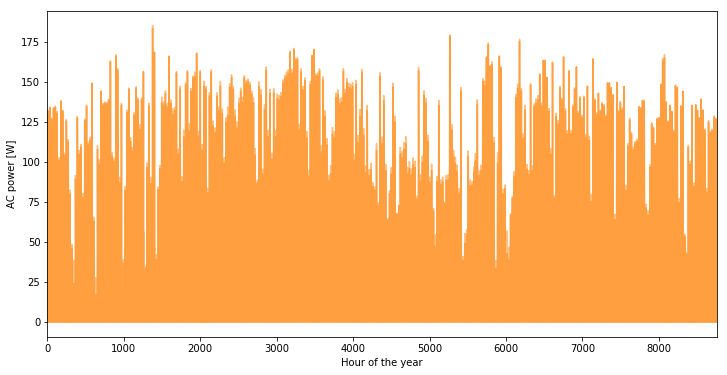

In [4]:
plot_x = np.arange(0, ddn.shape[0])

fig, ax = plt.subplots(figsize=[12,6])
ax.plot(plot_x, power, zorder = 1, color=colours.orange, alpha=0.5)
plt.ylabel('AC power [W]')
plt.xlabel('Hour of the year')
plt.xlim(plot_x[0], plot_x[-1])
plt.show()

In [5]:
# Do the same with Geneva data. Except Geneva has multiple weather files, so use a loop.
path_gen_folder = os.path.join('..', 'gen', 'historical')
list_genfiles = glob.glob(os.path.join(path_gen_folder, '*.{:s}'.format(file_type)))

# Declare a list.
gen_list = list()

for file in list_genfiles:
    
    gen_temp, locdata, header = wf.get_weather('gen', file, file_type=file_type)
    gen_list.append(gen_temp)
    
# Keep the list - useful for plotting and stuff later.
gen = pd.concat(gen_list)

In [6]:
power_syn_list = list()

for file in list_genfiles:
    power_syn_list.append(solar.tmy_to_power(path_tmy_data=file,
                                   surface_tilt=30, surface_azimuth=180,
                                   albedo=0.2, silent=True))

power_syn_df = pd.concat(power_syn_list)

C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Se

C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Se

In [8]:
print(power_syn_df.index)

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2013-12-31 14:00:00', '2013-12-31 15:00:00',
               '2013-12-31 16:00:00', '2013-12-31 17:00:00',
               '2013-12-31 18:00:00', '2013-12-31 19:00:00',
               '2013-12-31 20:00:00', '2013-12-31 21:00:00',
               '2013-12-31 22:00:00', '2013-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Time', length=315360, freq=None)


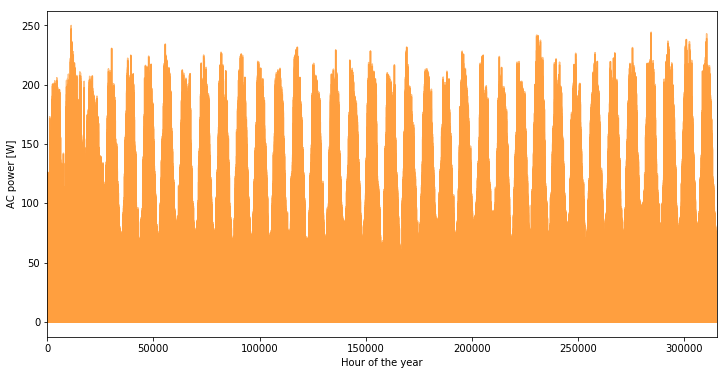

In [7]:
plot_x = np.arange(0, power_syn_df.shape[0])

fig, ax = plt.subplots(figsize=[12,6])
ax.plot(plot_x, power_syn_df, zorder = 1, color=colours.orange, alpha=0.5)
plt.ylabel('AC power [W]')
plt.xlabel('Hour of the year')
plt.xlim(plot_x[0], plot_x[-1])
plt.show()

## Uncertainty analysis with EPlus

### Steps/Notes

1. Consider weather inputs from Indra.
2. Run samples using EPlus - analyse results.
    1. Either modify a base EPlus file using Eppy/scripting or in jePlus.
    2. Or analyse the same EPlus file using many weather files.

<h2> Bibliography </h2>

<ul>
<li>Rastogi, Parag. 2016. “On the Sensitivity of Buildings to Climate: The Interaction of Weather and Building Envelopes in Determining Future Building Energy Consumption.” PhD, Lausanne, Switzerland: Ecole polytechnique fédérale de Lausanne. EPFL Infoscience. https://infoscience.epfl.ch/record/220971?ln=en.
<li>Rastogi, Parag, and Marilyne Andersen. 2015. “Embedding Stochasticity in Building Simulation Through Synthetic Weather Files.” In Proceedings of BS 2015. Hyderabad, India. http://infoscience.epfl.ch/record/208743.
<li>———. 2016. “Incorporating Climate Change Predictions in the Analysis of Weather-Based Uncertainty.” In Proceedings of SimBuild 2016. Salt Lake City, UT, USA. http://infoscience.epfl.ch/record/208743.
<li>Rastogi, Parag, Mohammad Emtiyaz Khan, and Marilyne Andersen. 2017. “Gaussian-Process-Based Emulators for Building Performance Simulation.” In Proceedings of BS 2017. San Francisco, CA, USA: IBPSA.
<li>Iaccarino, Gianluca. 2008. “Quantification of Uncertainty in Flow Simulations Using Probabilistic Methods.” presented at the VKI Lecture Series, Stanford University, September. http://web.stanford.edu/group/uq/uq_youq.html.
<li>Macdonald, Iain. 2002. “Quantifying the Effects of Uncertainty in Building Simulation.” Doctoral, University of Strathclyde. https://www.strath.ac.uk/media/departments/mechanicalengineering/esru/research/phdmphilprojects/macdonald_thesis.pdf.

</ul>